In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("data/train.csv")
train.head()

,id,name,popularity,duration_ms,artists,id_artists,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,release_year,release_month,release_day
0,269,blun7 a swishland,63,167760.0,['tha Supreme'],['19i93sA0D7yS9dYoVNBqAA'],0.692,0.792,7,-5.984,0.2450,0.1300,0.000000,0.2550,0.566,129.883,2019,11.0,15.0
1,27504,Que Me Perdone Tu Señora,42,150640.0,['Manoella Torres'],['4JRKcLbpjobmoOVoOXPd6y'],0.608,0.447,6,-12.151,0.0663,0.3350,0.000035,0.1690,0.673,90.777,2007,3.0,21.0
2,16082,愛唄~since 2007~,42,242373.0,['whiteeeen'],['6v3VFX2qIWthj4Lr5QIxts'],0.572,0.782,8,-5.275,0.0361,0.3060,0.000000,0.3740,0.450,170.050,2016,3.0,9.0
3,14585,Let me be your uncle tonight,12,202989.0,['Tvíhöfði'],['6rmrk3Jk0Ecf8fjioCCZmV'],0.855,0.470,7,-9.252,0.1620,0.0111,0.000002,0.2640,0.864,102.008,2001,1.0,1.0
4,14740,Never Going Back Again - 2004 Remaster,40,134400.0,['Fleetwood Mac'],['08GQAI4eElDnROBrJRGE0X'],0.654,0.336,6,-12.825,0.0379,0.8580,0.385000,0.0786,0.947,176.083,1977,2.0,4.0


In [3]:
artists = pd.read_csv("data/artists.csv")
artists.rename(columns={"popularity": "artist_popularity", "name": "artist_name", "id": "artist_id"}, inplace=True)
artists.head()

,artist_id,followers,genres,artist_name,artist_popularity
0,55CXG5KDJpRYwBopfYAJHa,21756,"['country blues', 'country rock', 'piedmont bl...",Jorma Kaukonen,40
1,08mjMUUjyTchMHCW7evc3R,640993,['turkish pop'],Hande Yener,62
2,3Ebn7mKYzD0L3DaUB1gNJZ,161509,"['celtic', 'irish folk']",Christy Moore,56
3,7GfaHcpmNcrcHoyGnOBsAz,9578,"['kindermusik', 'kleine hoerspiel']",Die Biene Maja,56
4,1DYXGLnfNDt8mO2aK9k83j,48876,"['opm', 'vispop']",Jay-R Siaboc,39


In [4]:
train.shape

(21000, 19)

In [5]:
train.columns

Index(['id', 'name', 'popularity', 'duration_ms', 'artists', 'id_artists',
       'danceability', 'energy', 'key', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'release_year', 'release_month', 'release_day'],
      dtype='object')

<AxesSubplot:>

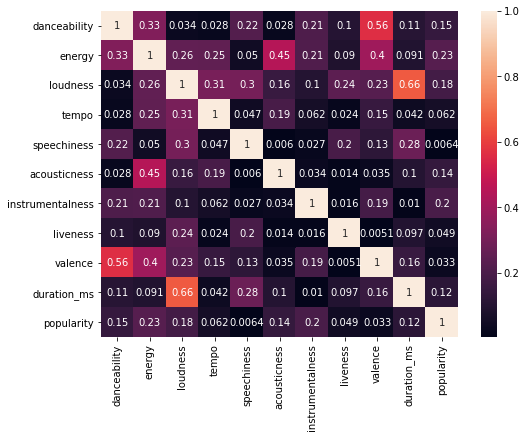

In [6]:
quant_cols = [
        'danceability', 'energy', 'loudness', 'tempo', 'speechiness',
        'acousticness', 'instrumentalness', 'liveness', 'valence', 'duration_ms',
        'popularity'
]
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(np.abs(np.log(train[quant_cols]).corr()), annot=True, ax=ax)

In [7]:
df = train.copy()
df['main_artist'] = (
    df['artists']
    .str.replace("[\[\]']+", "", regex=True)
    .str.split(",", expand=True)[0]
)
df['id_main_artist'] = (
    df['id_artists']
    .str.replace("[\[\]']+", "", regex=True)
    .str.split(",", expand=True)[0]
)
df = df.merge(artists, how='left', left_on='id_main_artist', right_on='artist_id')
df.fillna(0, inplace=True)
df

,id,name,popularity,duration_ms,artists,id_artists,danceability,energy,key,loudness,...,release_year,release_month,release_day,main_artist,id_main_artist,artist_id,followers,genres,artist_name,artist_popularity
0,269,blun7 a swishland,63,167760.0,['tha Supreme'],['19i93sA0D7yS9dYoVNBqAA'],0.692,0.792,7,-5.984,...,2019,11.0,15.0,tha Supreme,19i93sA0D7yS9dYoVNBqAA,19i93sA0D7yS9dYoVNBqAA,1337237.0,"['italian hip hop', 'italian pop', 'trap itali...",tha Supreme,73.0
1,27504,Que Me Perdone Tu Señora,42,150640.0,['Manoella Torres'],['4JRKcLbpjobmoOVoOXPd6y'],0.608,0.447,6,-12.151,...,2007,3.0,21.0,Manoella Torres,4JRKcLbpjobmoOVoOXPd6y,4JRKcLbpjobmoOVoOXPd6y,86333.0,"['latin pop', 'mexican rock-and-roll', 'pop ro...",Manoella Torres,49.0
2,16082,愛唄~since 2007~,42,242373.0,['whiteeeen'],['6v3VFX2qIWthj4Lr5QIxts'],0.572,0.782,8,-5.275,...,2016,3.0,9.0,whiteeeen,6v3VFX2qIWthj4Lr5QIxts,6v3VFX2qIWthj4Lr5QIxts,18320.0,['j-pop girl group'],whiteeeen,36.0
3,14585,Let me be your uncle tonight,12,202989.0,['Tvíhöfði'],['6rmrk3Jk0Ecf8fjioCCZmV'],0.855,0.470,7,-9.252,...,2001,1.0,1.0,Tvíhöfði,6rmrk3Jk0Ecf8fjioCCZmV,6rmrk3Jk0Ecf8fjioCCZmV,1882.0,"['classic icelandic pop', 'icelandic indie', '...",Tvíhöfði,19.0
4,14740,Never Going Back Again - 2004 Remaster,40,134400.0,['Fleetwood Mac'],['08GQAI4eElDnROBrJRGE0X'],0.654,0.336,6,-12.825,...,1977,2.0,4.0,Fleetwood Mac,08GQAI4eElDnROBrJRGE0X,08GQAI4eElDnROBrJRGE0X,6343791.0,"['album rock', 'classic rock', 'mellow gold', ...",Fleetwood Mac,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,10659,Feuer frei!,60,188600.0,['Rammstein'],['6wWVKhxIU2cEi0K81v7HvP'],0.491,0.966,3,-3.974,...,2001,4.0,2.0,Rammstein,6wWVKhxIU2cEi0K81v7HvP,6wWVKhxIU2cEi0K81v7HvP,5750041.0,"['alternative metal', 'german metal', 'industr...",Rammstein,80.0
20996,14678,Kapitel 22 - Die Lippizaner (Folge 018),33,94139.0,['Bibi und Tina'],['2x8vG4f0HYXzMEo3xNsoiI'],0.758,0.416,2,-17.929,...,1994,0.0,0.0,Bibi und Tina,2x8vG4f0HYXzMEo3xNsoiI,2x8vG4f0HYXzMEo3xNsoiI,125018.0,"['hoerspiel', 'kleine hoerspiel']",Bibi und Tina,80.0
20997,1419,Kaadhal Solvadhu,34,276120.0,"['Srinivas', 'Sunitha']","['3K9qRRRqtuxgBRLxRCxpDl', '74S8YRi4XQ5yf9ToSz...",0.695,0.464,7,-8.277,...,2001,2.0,11.0,Srinivas,3K9qRRRqtuxgBRLxRCxpDl,3K9qRRRqtuxgBRLxRCxpDl,465205.0,"['filmi', 'tamil pop']",Srinivas,56.0
20998,14713,039 - Die Gift-Party - Teil 12,30,102440.0,['TKKG Retro-Archiv'],['0i38tQX5j4gZ0KS3eCMoIl'],0.663,0.548,9,-9.953,...,1985,6.0,1.0,TKKG Retro-Archiv,0i38tQX5j4gZ0KS3eCMoIl,0i38tQX5j4gZ0KS3eCMoIl,23593.0,['kleine hoerspiel'],TKKG Retro-Archiv,71.0


In [8]:
df['popularity'].corr(df['artist_popularity'])

0.5232834839028944

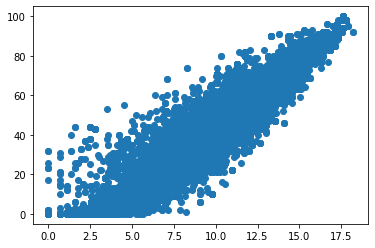

In [9]:
plt.scatter(np.log(df['followers']), df['artist_popularity'])

<AxesSubplot:xlabel='popularity', ylabel='Count'>

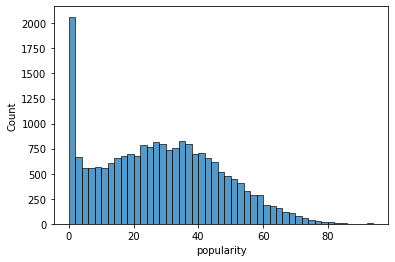

In [10]:
sns.histplot(df['popularity'])

In [11]:
df[df['popularity'] == 0]

,id,name,popularity,duration_ms,artists,id_artists,danceability,energy,key,loudness,...,release_year,release_month,release_day,main_artist,id_main_artist,artist_id,followers,genres,artist_name,artist_popularity
28,11939,This Year's Kisses - 2010 Remastered Version,0,187853.0,['Billie Holiday'],['1YzCsTRb22dQkh9lghPIrp'],0.685,0.310,7,-9.274,...,2010,10.0,25.0,Billie Holiday,1YzCsTRb22dQkh9lghPIrp,1YzCsTRb22dQkh9lghPIrp,1411671.0,"['adult standards', 'harlem renaissance', 'jaz...",Billie Holiday,70.0
42,11706,Latin Piano - Original Mix,0,435000.0,['Marcus Hype'],['49S5N4Qw9e719ThFIgGVQu'],0.596,0.995,4,-3.820,...,2014,12.0,8.0,Marcus Hype,49S5N4Qw9e719ThFIgGVQu,0,0.0,0,0,0.0
50,13195,Saraasaraangal,0,168680.0,['M. K. Thyagaraja Bhagavathar'],['64LJVsjBP6bkbacv9SmepY'],0.635,0.467,6,-9.689,...,1939,12.0,31.0,M. K. Thyagaraja Bhagavathar,64LJVsjBP6bkbacv9SmepY,64LJVsjBP6bkbacv9SmepY,1204.0,['carnatic'],M. K. Thyagaraja Bhagavathar,9.0
53,13567,Breeze - Radio,0,172090.0,['Patrick Aurelle'],['0oJ0NhXYOMIvoOLWj6B4dI'],0.663,0.752,5,-5.751,...,2017,1.0,30.0,Patrick Aurelle,0oJ0NhXYOMIvoOLWj6B4dI,0oJ0NhXYOMIvoOLWj6B4dI,128.0,['deep pop edm'],Patrick Aurelle,11.0
60,23611,No Man's Land,0,162533.0,['Bill Anderson'],['0gWNSMYCSHF4wxIs1XTSDh'],0.634,0.346,5,-12.063,...,2011,6.0,13.0,Bill Anderson,0gWNSMYCSHF4wxIs1XTSDh,0gWNSMYCSHF4wxIs1XTSDh,47083.0,['nashville sound'],Bill Anderson,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20917,25746,La Blouse Francaise,0,176480.0,['Sydney Landry'],['7FftFMbiwByrcHhbRD4vzQ'],0.471,0.225,9,-13.800,...,1928,0.0,0.0,Sydney Landry,7FftFMbiwByrcHhbRD4vzQ,7FftFMbiwByrcHhbRD4vzQ,2.0,[],Sydney Landry,0.0
20930,7456,Bansuriya Toot Gai Man Ki,0,177966.0,['Shamshad Begum'],['0Ury0QIiBOlJmsdYUiCTfQ'],0.544,0.216,10,-9.422,...,1947,12.0,31.0,Shamshad Begum,0Ury0QIiBOlJmsdYUiCTfQ,0Ury0QIiBOlJmsdYUiCTfQ,185804.0,"['classic bollywood', 'classic pakistani pop',...",Shamshad Begum,37.0
20934,6891,Only Teardrops (Denmark Eurovision Entry 2013),0,185946.0,['Jogging & Running'],['0MEYR2qj1svAAMJZ9AWCaJ'],0.542,0.890,0,-3.640,...,2021,1.0,18.0,Jogging & Running,0MEYR2qj1svAAMJZ9AWCaJ,0,0.0,0,0,0.0
20976,6416,The Man From The South,0,172106.0,['Rube Bloom & His Bayou Boys'],['2aFYuatfbCkMjmbjHjGwJA'],0.856,0.474,7,-10.549,...,1925,0.0,0.0,Rube Bloom & His Bayou Boys,2aFYuatfbCkMjmbjHjGwJA,2aFYuatfbCkMjmbjHjGwJA,14.0,[],Rube Bloom & His Bayou Boys,0.0


<AxesSubplot:xlabel='loudness', ylabel='Count'>

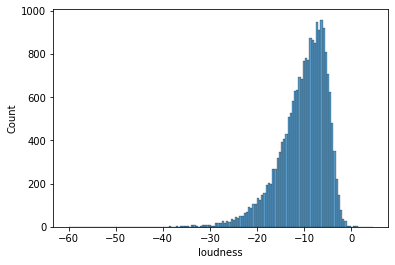

In [12]:
sns.histplot(df['loudness'])

In [13]:
df[df['main_artist'] == "Fleetwood Mac"]

,id,name,popularity,duration_ms,artists,id_artists,danceability,energy,key,loudness,...,release_year,release_month,release_day,main_artist,id_main_artist,artist_id,followers,genres,artist_name,artist_popularity
4,14740,Never Going Back Again - 2004 Remaster,40,134400.0,['Fleetwood Mac'],['08GQAI4eElDnROBrJRGE0X'],0.654,0.336,6,-12.825,...,1977,2.0,4.0,Fleetwood Mac,08GQAI4eElDnROBrJRGE0X,08GQAI4eElDnROBrJRGE0X,6343791.0,"['album rock', 'classic rock', 'mellow gold', ...",Fleetwood Mac,85.0
782,3339,Tusk - 2018 Remaster,49,218867.0,['Fleetwood Mac'],['08GQAI4eElDnROBrJRGE0X'],0.613,0.785,9,-11.856,...,2018,11.0,16.0,Fleetwood Mac,08GQAI4eElDnROBrJRGE0X,08GQAI4eElDnROBrJRGE0X,6343791.0,"['album rock', 'classic rock', 'mellow gold', ...",Fleetwood Mac,85.0
2445,16406,Save Me a Place - 2015 Remaster,36,162293.0,['Fleetwood Mac'],['08GQAI4eElDnROBrJRGE0X'],0.760,0.428,6,-11.147,...,1979,10.0,12.0,Fleetwood Mac,08GQAI4eElDnROBrJRGE0X,08GQAI4eElDnROBrJRGE0X,6343791.0,"['album rock', 'classic rock', 'mellow gold', ...",Fleetwood Mac,85.0
5871,14736,Over My Head - 2018 Remaster,33,189533.0,['Fleetwood Mac'],['08GQAI4eElDnROBrJRGE0X'],0.611,0.637,2,-10.822,...,2018,11.0,16.0,Fleetwood Mac,08GQAI4eElDnROBrJRGE0X,08GQAI4eElDnROBrJRGE0X,6343791.0,"['album rock', 'classic rock', 'mellow gold', ...",Fleetwood Mac,85.0
6976,10806,Dreams,71,254453.0,['Fleetwood Mac'],['08GQAI4eElDnROBrJRGE0X'],0.823,0.338,0,-15.899,...,1988,11.0,21.0,Fleetwood Mac,08GQAI4eElDnROBrJRGE0X,08GQAI4eElDnROBrJRGE0X,6343791.0,"['album rock', 'classic rock', 'mellow gold', ...",Fleetwood Mac,85.0
12308,12032,The Chain - 2004 Remaster,41,270213.0,['Fleetwood Mac'],['08GQAI4eElDnROBrJRGE0X'],0.545,0.670,9,-8.810,...,1977,2.0,4.0,Fleetwood Mac,08GQAI4eElDnROBrJRGE0X,08GQAI4eElDnROBrJRGE0X,6343791.0,"['album rock', 'classic rock', 'mellow gold', ...",Fleetwood Mac,85.0
12903,20930,Coming Your Way - 2013 Remaster,30,225612.0,['Fleetwood Mac'],['08GQAI4eElDnROBrJRGE0X'],0.558,0.624,4,-14.790,...,1969,9.0,19.0,Fleetwood Mac,08GQAI4eElDnROBrJRGE0X,08GQAI4eElDnROBrJRGE0X,6343791.0,"['album rock', 'classic rock', 'mellow gold', ...",Fleetwood Mac,85.0
15005,2562,Landslide,79,199493.0,['Fleetwood Mac'],['08GQAI4eElDnROBrJRGE0X'],0.414,0.161,7,-22.320,...,1975,7.0,11.0,Fleetwood Mac,08GQAI4eElDnROBrJRGE0X,08GQAI4eElDnROBrJRGE0X,6343791.0,"['album rock', 'classic rock', 'mellow gold', ...",Fleetwood Mac,85.0
16752,976,The World Keep on Turning,23,149027.0,['Fleetwood Mac'],['08GQAI4eElDnROBrJRGE0X'],0.736,0.221,0,-14.633,...,1968,2.0,24.0,Fleetwood Mac,08GQAI4eElDnROBrJRGE0X,08GQAI4eElDnROBrJRGE0X,6343791.0,"['album rock', 'classic rock', 'mellow gold', ...",Fleetwood Mac,85.0
16982,11497,Oh Well (Pt. 1) - 2013 Remaster,31,204439.0,['Fleetwood Mac'],['08GQAI4eElDnROBrJRGE0X'],0.466,0.623,4,-10.474,...,1969,9.0,19.0,Fleetwood Mac,08GQAI4eElDnROBrJRGE0X,08GQAI4eElDnROBrJRGE0X,6343791.0,"['album rock', 'classic rock', 'mellow gold', ...",Fleetwood Mac,85.0


In [21]:
df['release_decade'] = (df['release_year'] // 10) * 10
df.groupby('release_decade')['popularity'].mean()
df = pd.concat([df, pd.get_dummies(df, columns=['release_decade'])], axis=1)
df

,id,name,popularity,duration_ms,artists,id_artists,danceability,energy,key,loudness,...,release_decade_1930,release_decade_1940,release_decade_1950,release_decade_1960,release_decade_1970,release_decade_1980,release_decade_1990,release_decade_2000,release_decade_2010,release_decade_2020
0,269,blun7 a swishland,63,167760.0,['tha Supreme'],['19i93sA0D7yS9dYoVNBqAA'],0.692,0.792,7,-5.984,...,0,0,0,0,0,0,0,0,1,0
1,27504,Que Me Perdone Tu Señora,42,150640.0,['Manoella Torres'],['4JRKcLbpjobmoOVoOXPd6y'],0.608,0.447,6,-12.151,...,0,0,0,0,0,0,0,1,0,0
2,16082,愛唄~since 2007~,42,242373.0,['whiteeeen'],['6v3VFX2qIWthj4Lr5QIxts'],0.572,0.782,8,-5.275,...,0,0,0,0,0,0,0,0,1,0
3,14585,Let me be your uncle tonight,12,202989.0,['Tvíhöfði'],['6rmrk3Jk0Ecf8fjioCCZmV'],0.855,0.470,7,-9.252,...,0,0,0,0,0,0,0,1,0,0
4,14740,Never Going Back Again - 2004 Remaster,40,134400.0,['Fleetwood Mac'],['08GQAI4eElDnROBrJRGE0X'],0.654,0.336,6,-12.825,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,10659,Feuer frei!,60,188600.0,['Rammstein'],['6wWVKhxIU2cEi0K81v7HvP'],0.491,0.966,3,-3.974,...,0,0,0,0,0,0,0,1,0,0
20996,14678,Kapitel 22 - Die Lippizaner (Folge 018),33,94139.0,['Bibi und Tina'],['2x8vG4f0HYXzMEo3xNsoiI'],0.758,0.416,2,-17.929,...,0,0,0,0,0,0,1,0,0,0
20997,1419,Kaadhal Solvadhu,34,276120.0,"['Srinivas', 'Sunitha']","['3K9qRRRqtuxgBRLxRCxpDl', '74S8YRi4XQ5yf9ToSz...",0.695,0.464,7,-8.277,...,0,0,0,0,0,0,0,1,0,0
20998,14713,039 - Die Gift-Party - Teil 12,30,102440.0,['TKKG Retro-Archiv'],['0i38tQX5j4gZ0KS3eCMoIl'],0.663,0.548,9,-9.953,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
def create_design_matrix(data):
    
    # Joining with the artists table
    df = data.copy()
    df['main_artist'] = (
        df['artists']
        .str.replace("[\[\]']+", "", regex=True)
        .str.split(",", expand=True)[0]
    )
    df['id_main_artist'] = (
        df['id_artists']
        .str.replace("[\[\]']+", "", regex=True)
        .str.split(",", expand=True)[0]
    )
    df = df.merge(artists, how='left', left_on='id_main_artist', right_on='artist_id')
    df.fillna(0, inplace=True)
    
    # One Hot Encode Release Decade
    df['release_decade'] = (df['release_year'] // 10) * 10
    df = pd.concat([df, pd.get_dummies(df, columns=['release_decade'])], axis=1)